# SHAP Values Analysis

SHAP (SHapley Additive exPlanations) estimates how much each input feature contributes to a prediction by assigning an importance value called a Shapley value. This value shows how much the feature pushes the model’s output away from or toward a baseline (usually the average prediction).

In this notebook, we analyze SHAP values generated for our drug synergy prediction models (Biomining, TranSynergy).

In [1]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [2]:
from explainability.shapley.utils import load_shap_data

bio_shap_values, bio_inputs, bio_feature_names, bio_indices = load_shap_data("biomining")
tran_shap_values, tran_inputs, tran_feature_names, tran_indices = load_shap_data("transynergy")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


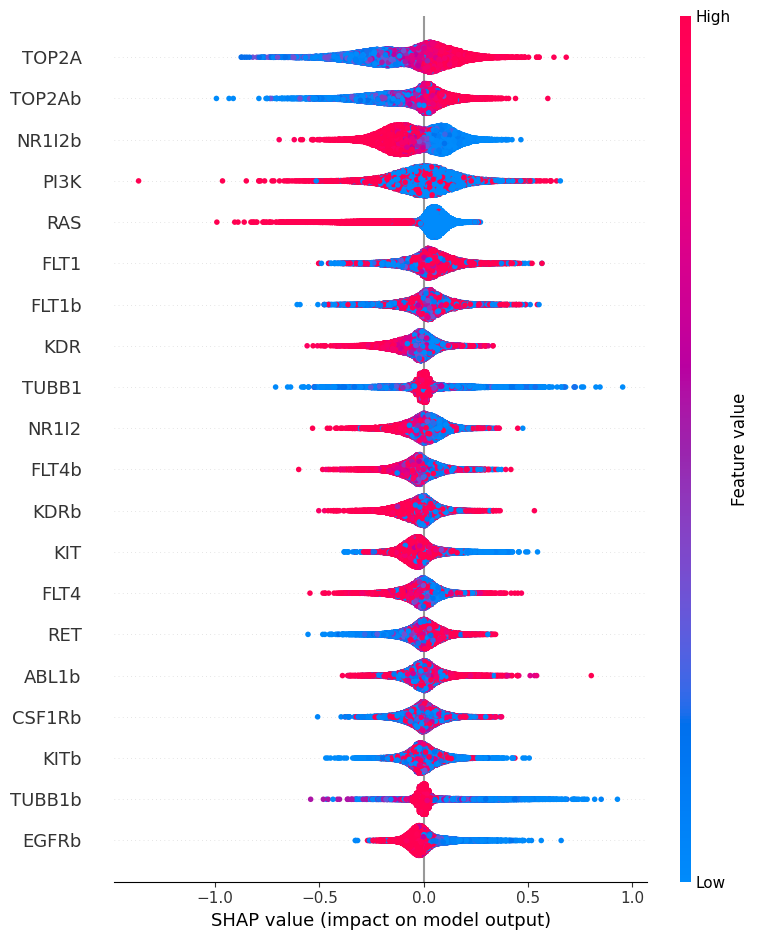

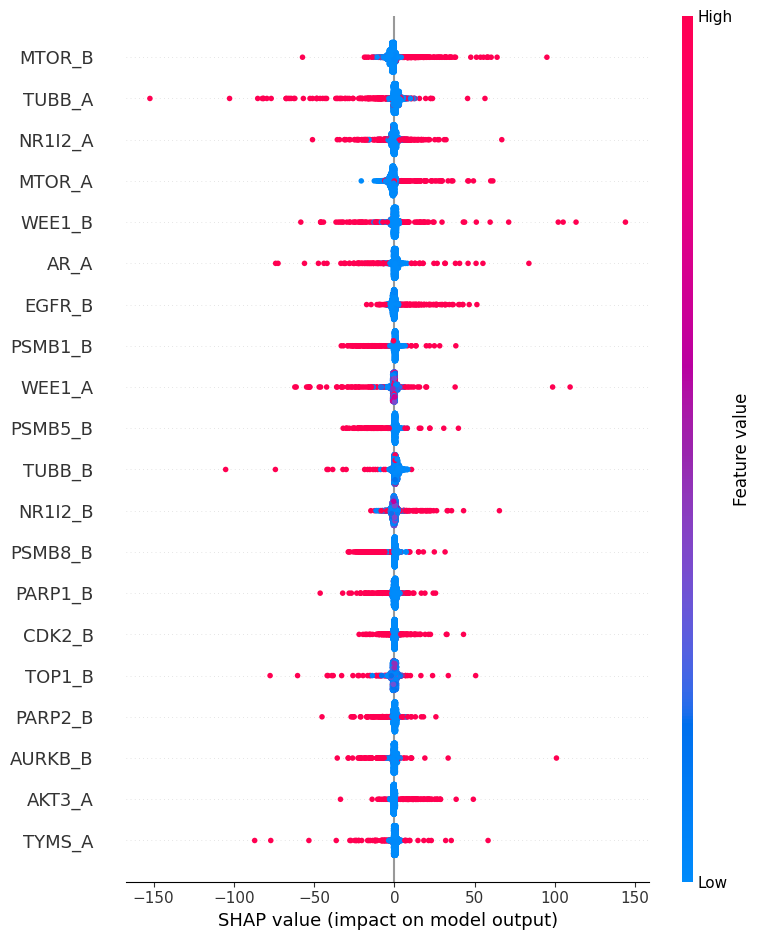

In [3]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(bio_shap_values, bio_inputs, bio_feature_names)
shap.summary_plot(tran_shap_values, tran_inputs, tran_feature_names)
plt.show()

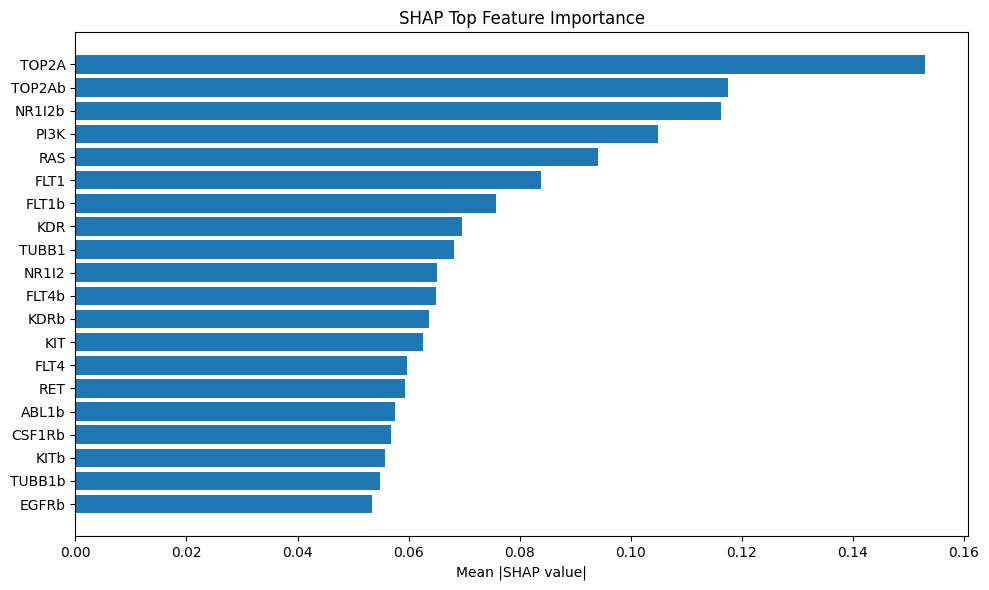

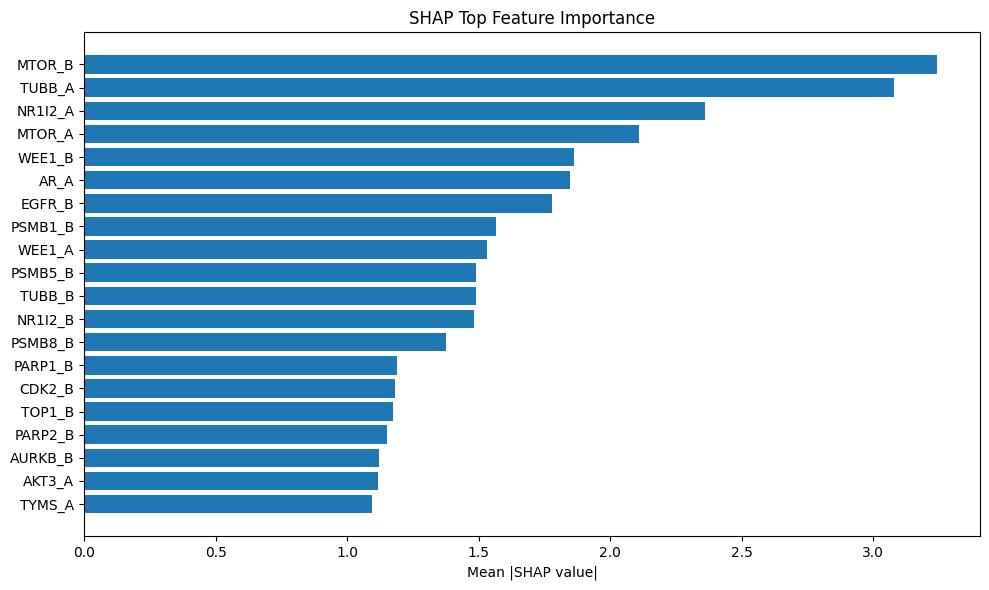

In [6]:
import numpy as np
import pandas as pd

def plot_feature_importance(shap_values, feature_names, top_n=20):
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
    plt.xlabel("Mean |SHAP value|")
    plt.title("SHAP Top Feature Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(bio_shap_values, bio_feature_names)
plot_feature_importance(tran_shap_values, tran_feature_names)

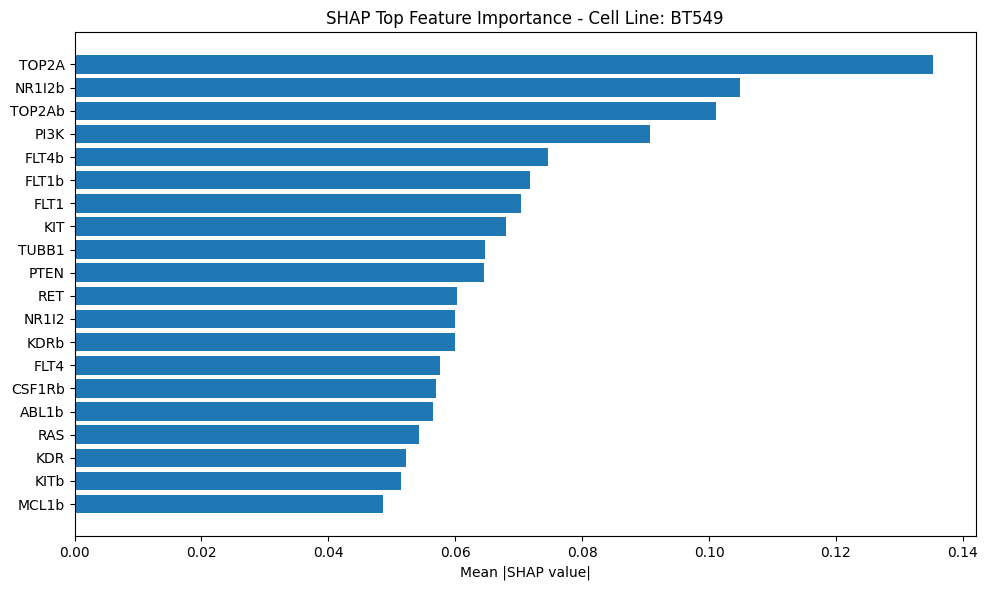

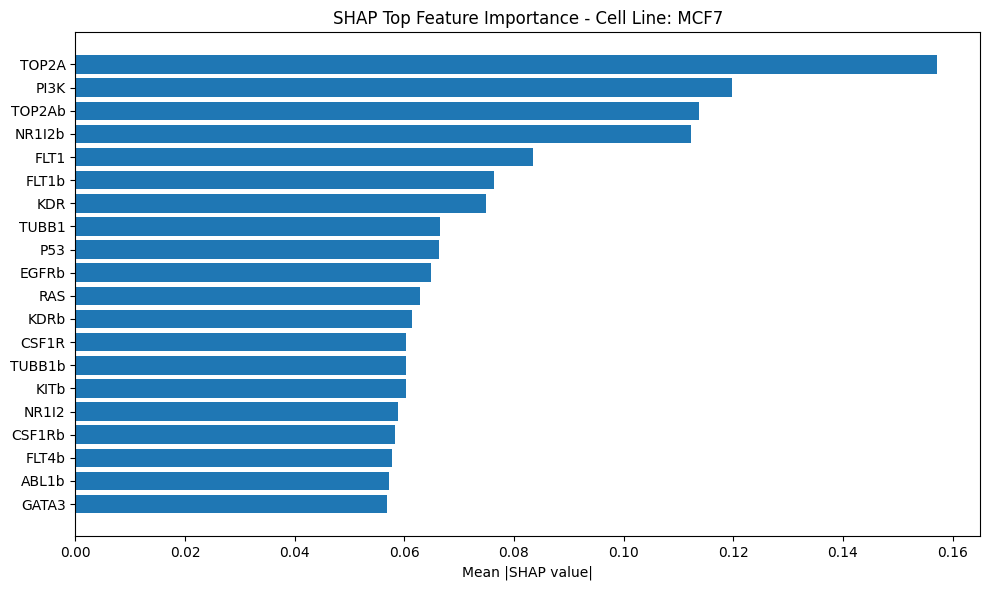

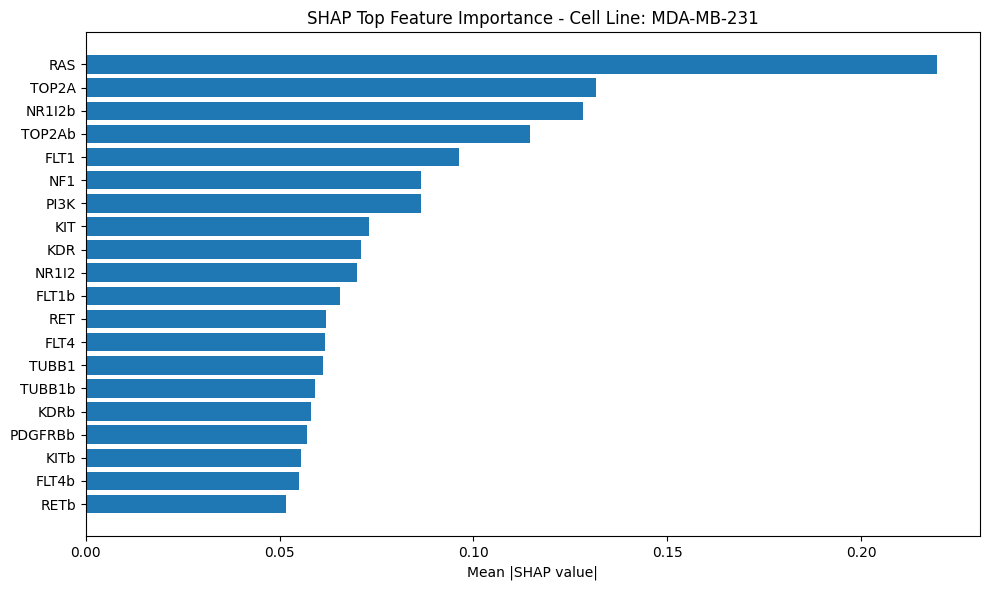

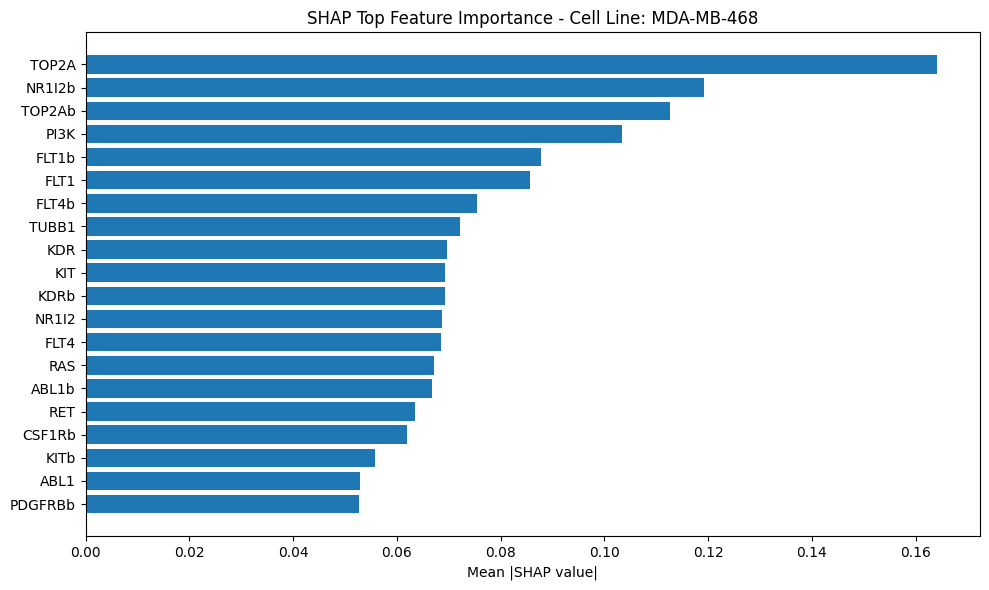

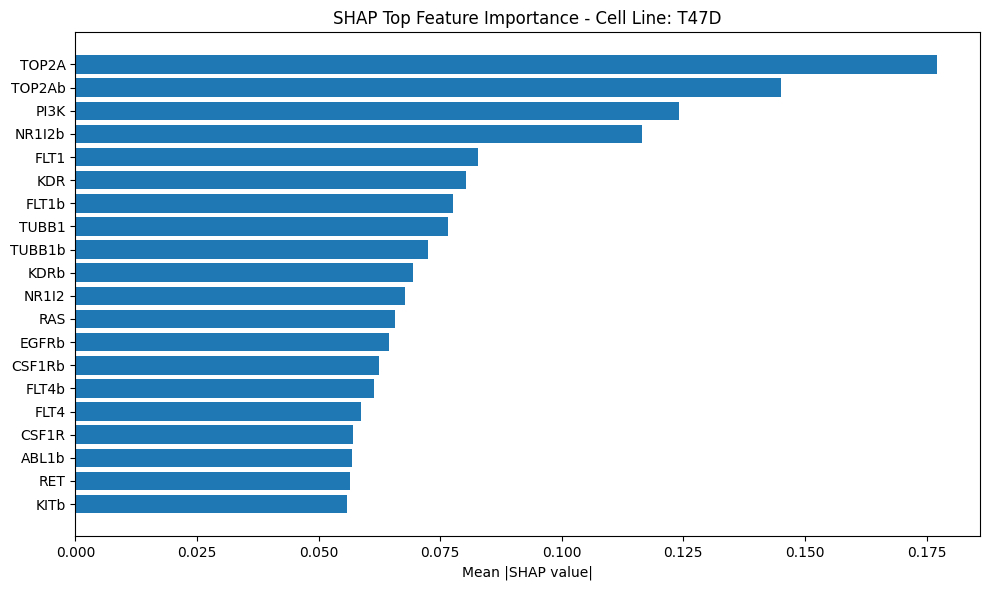

In [7]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_by_cell_line(shap_values, feature_names, bio_indices, top_n=20):
    cell_lines = load_biomining_cell_line_data(split='test')
    #because of permutation
    cell_lines = np.concatenate([cell_lines, cell_lines], axis=0)
    #only get the cell lines that were used for SHAP
    sampled_cell_lines = cell_lines[bio_indices]
    
    unique_cell_lines = np.unique(sampled_cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(sampled_cell_lines == cell_line)[0]
        cell_line_shap_values = shap_values[cell_line_indices]
        
        mean_abs_shap = np.mean(np.abs(cell_line_shap_values), axis=0)
        
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs_shap
        }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
        plt.xlabel("Mean |SHAP value|")
        plt.title(f"SHAP Top Feature Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_cell_line(bio_shap_values, bio_feature_names, bio_indices)


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


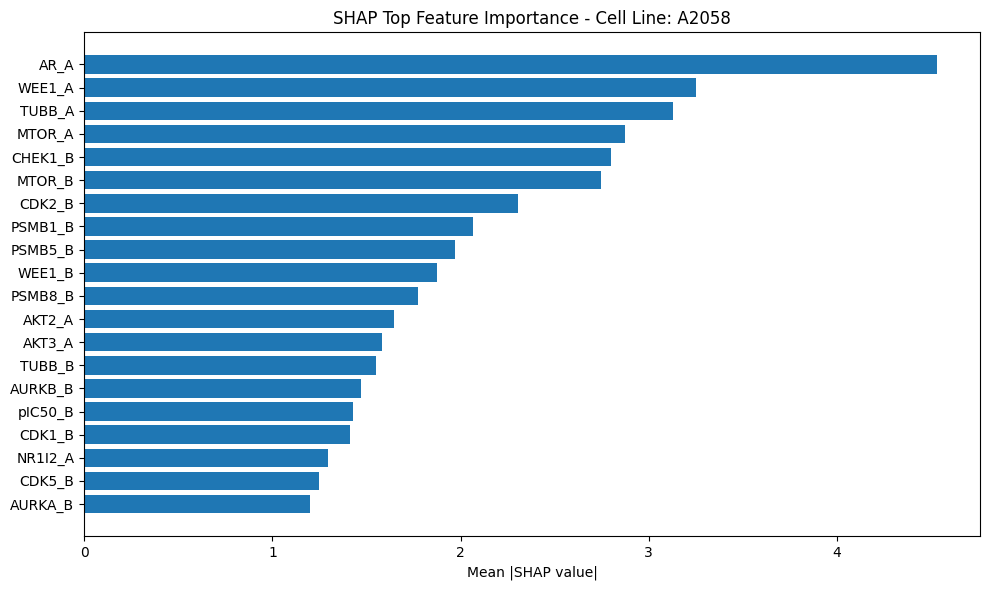

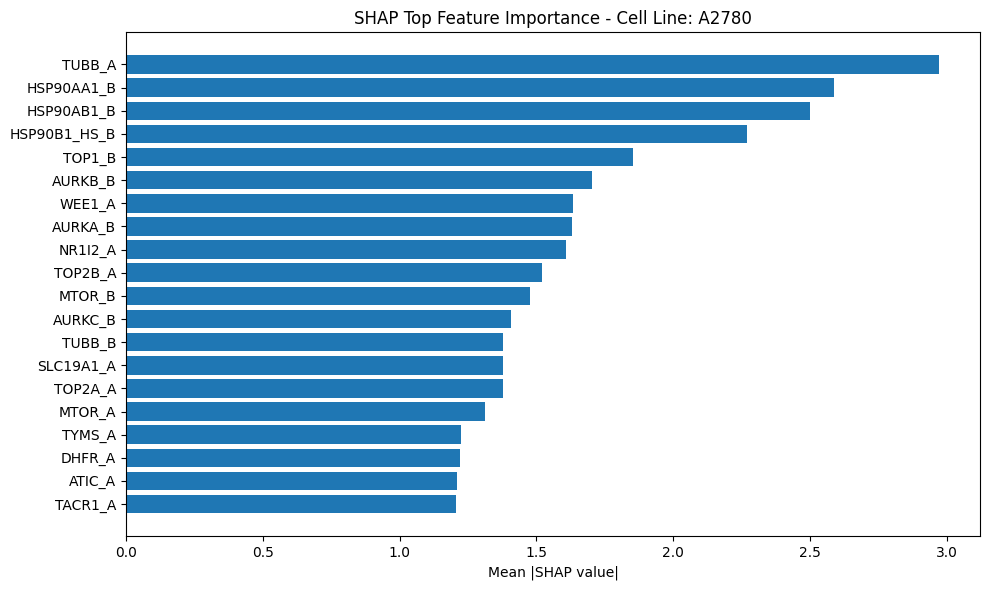

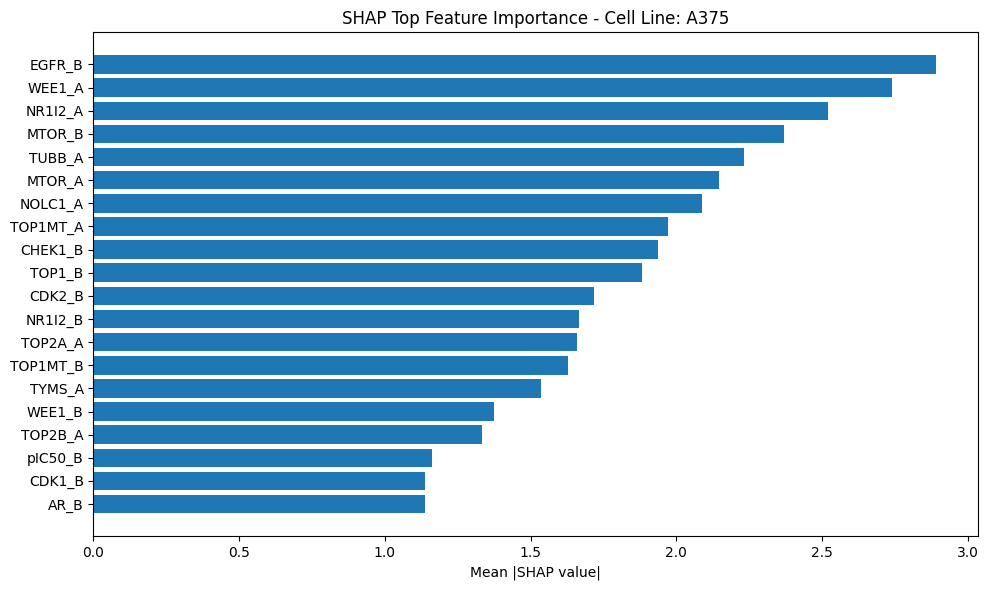

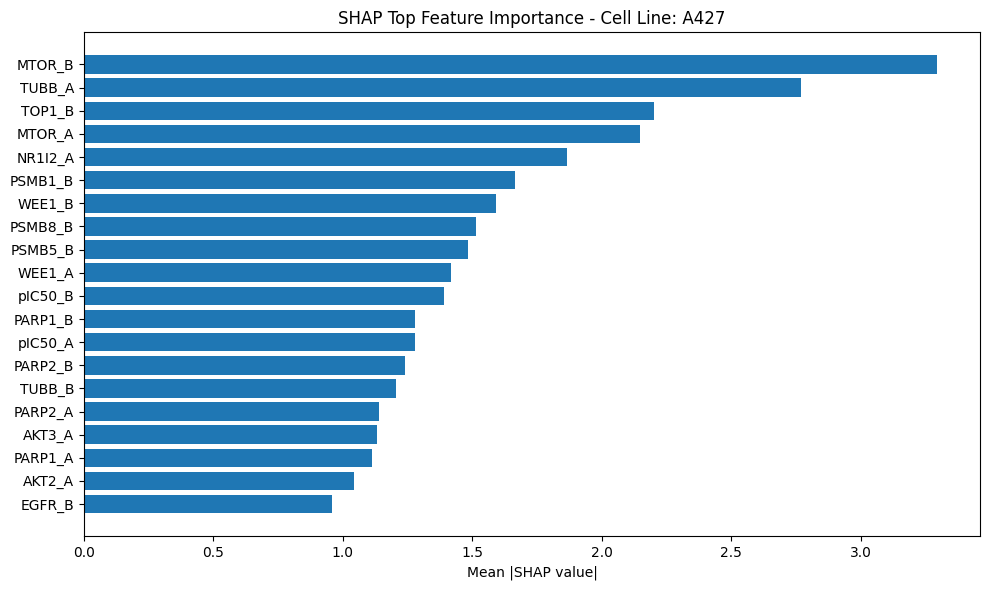

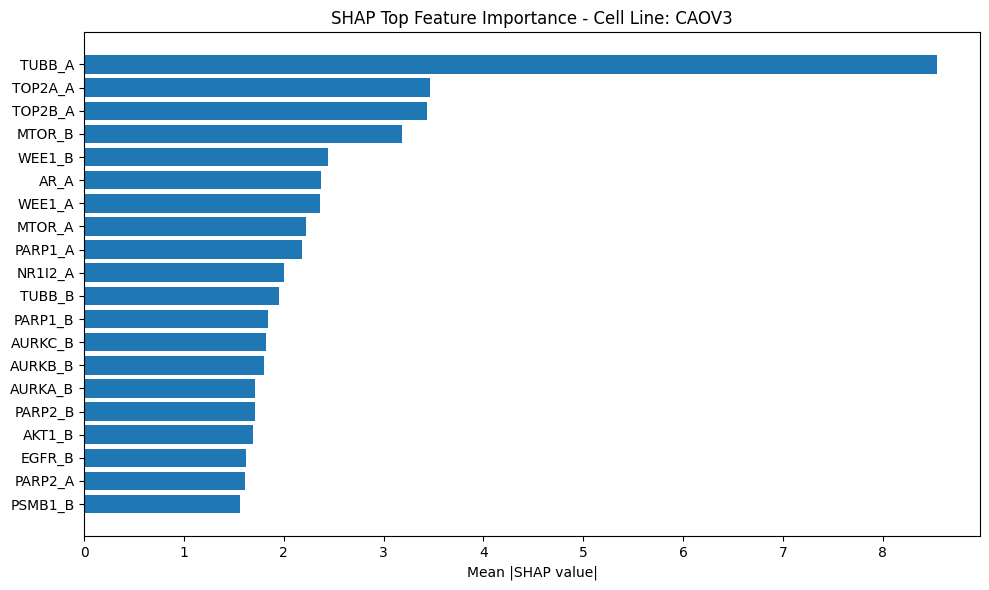

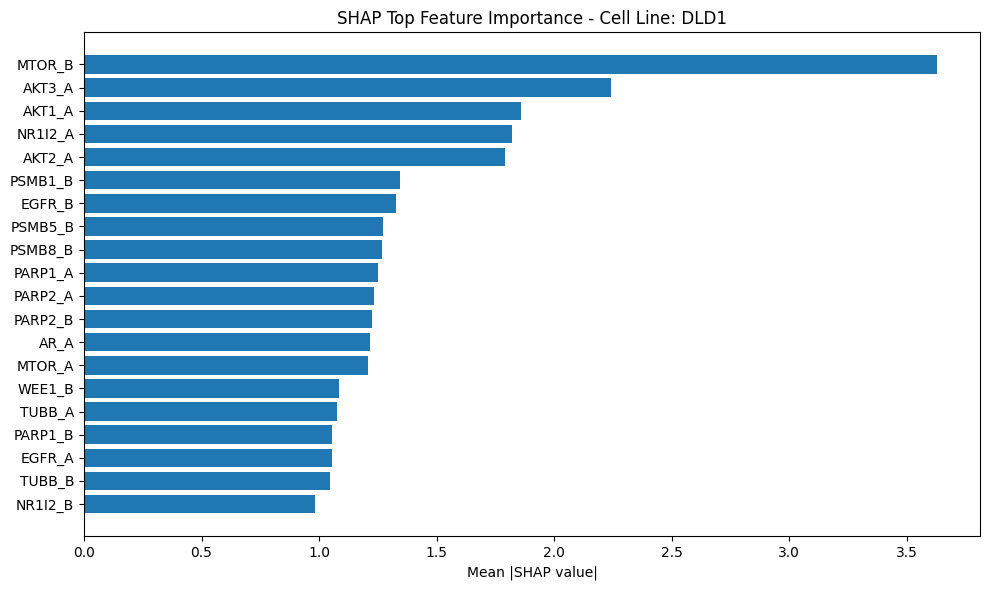

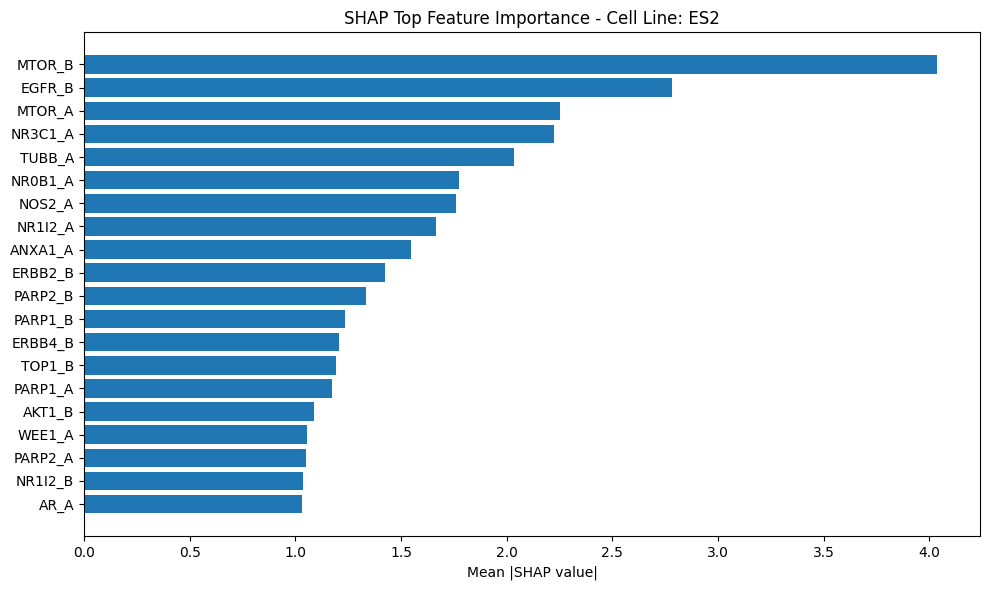

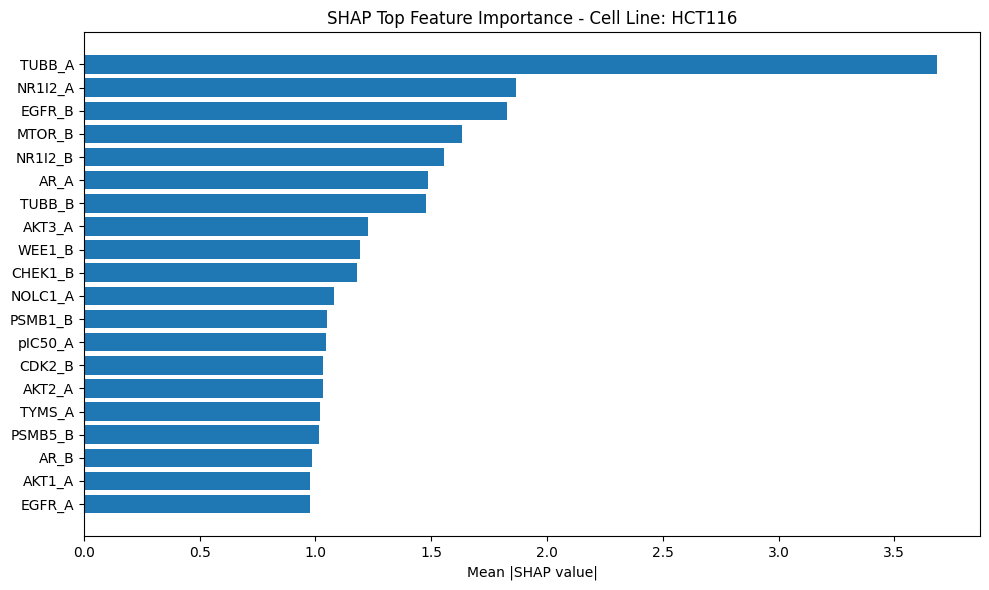

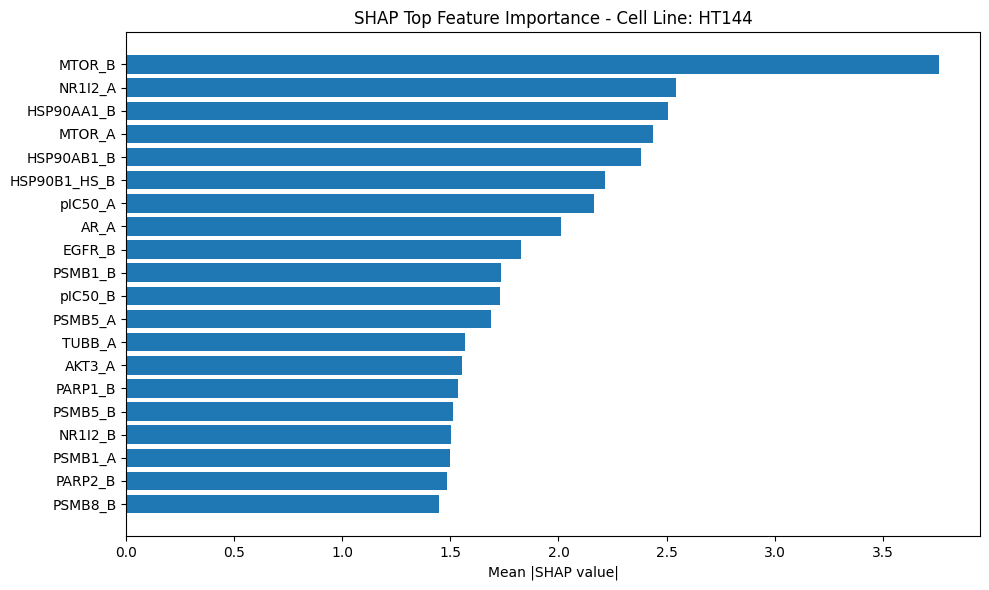

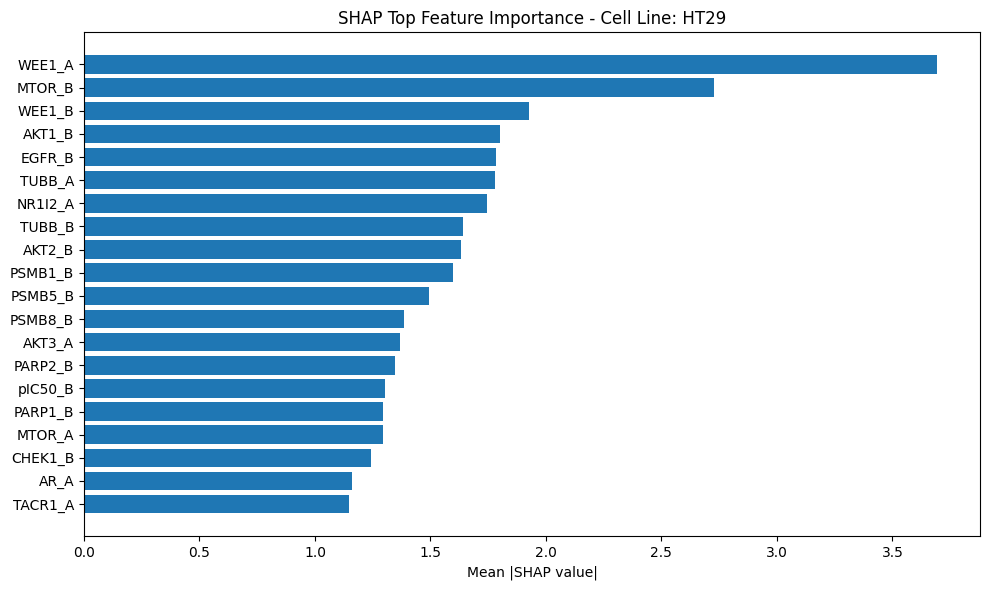

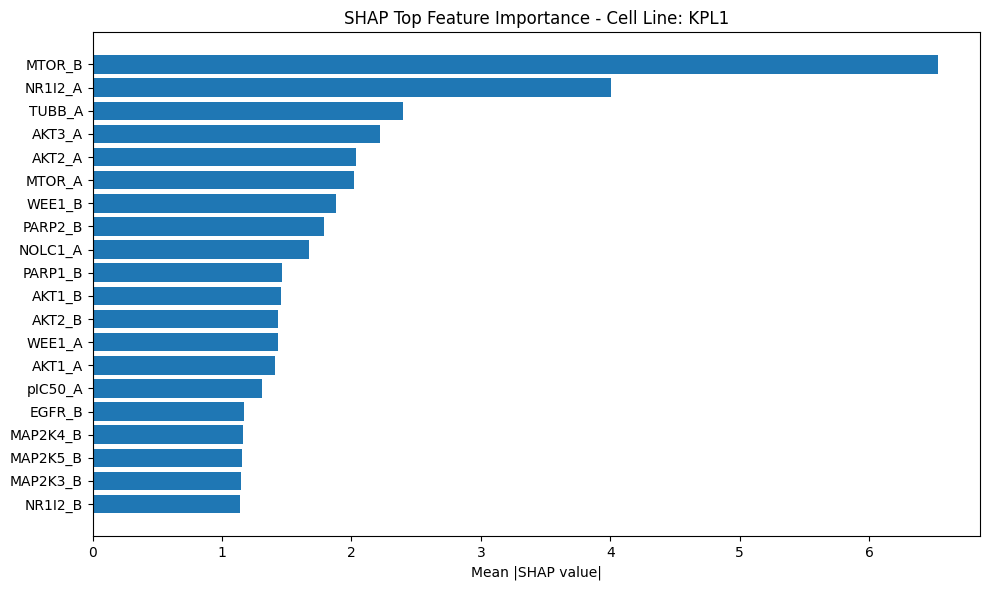

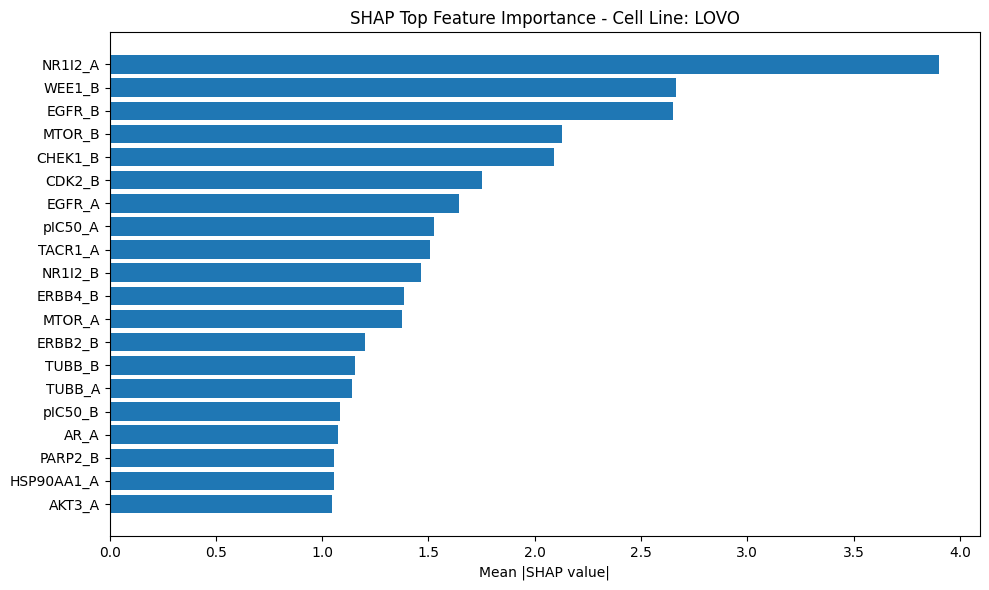

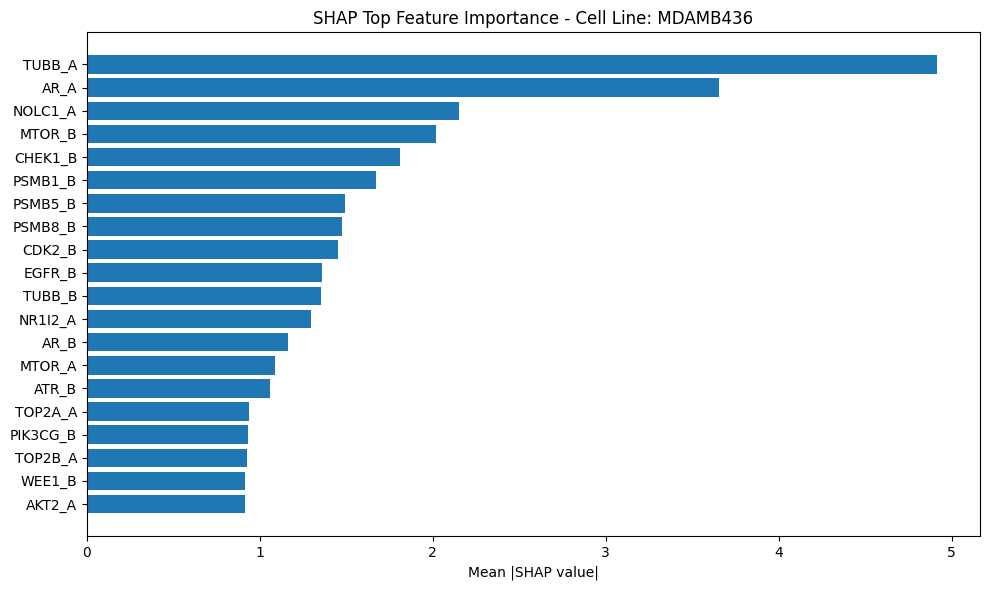

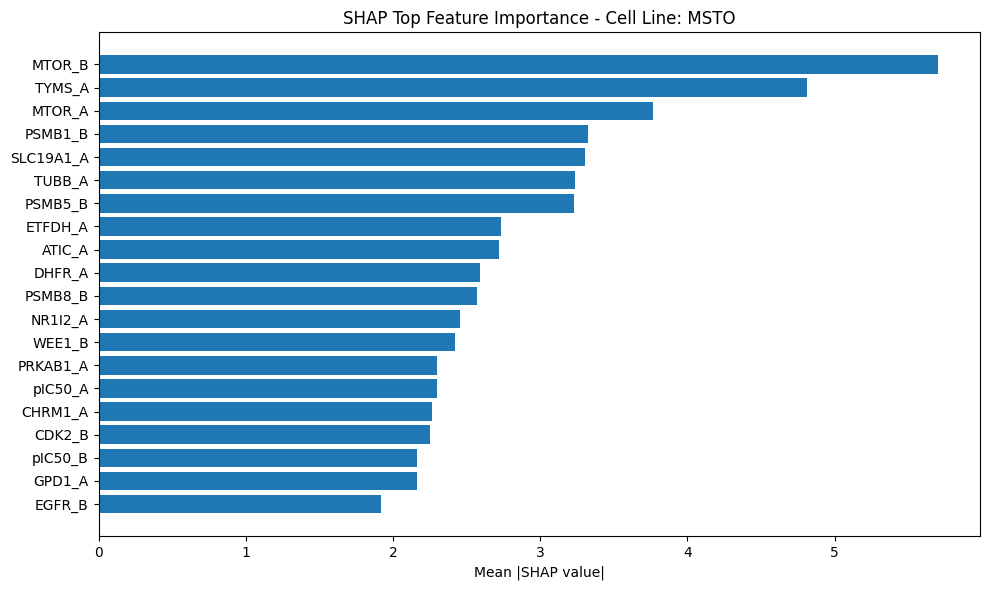

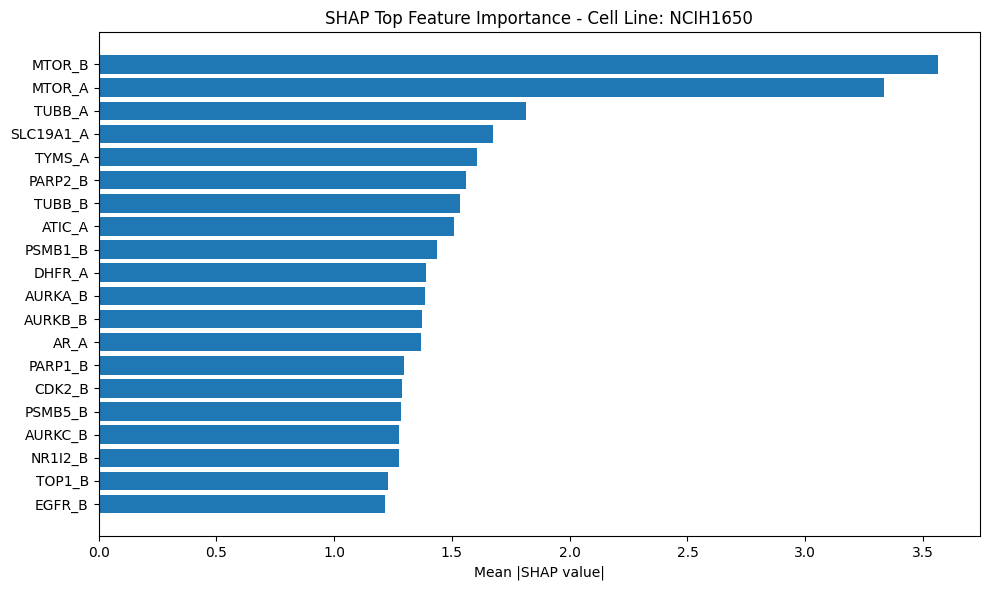

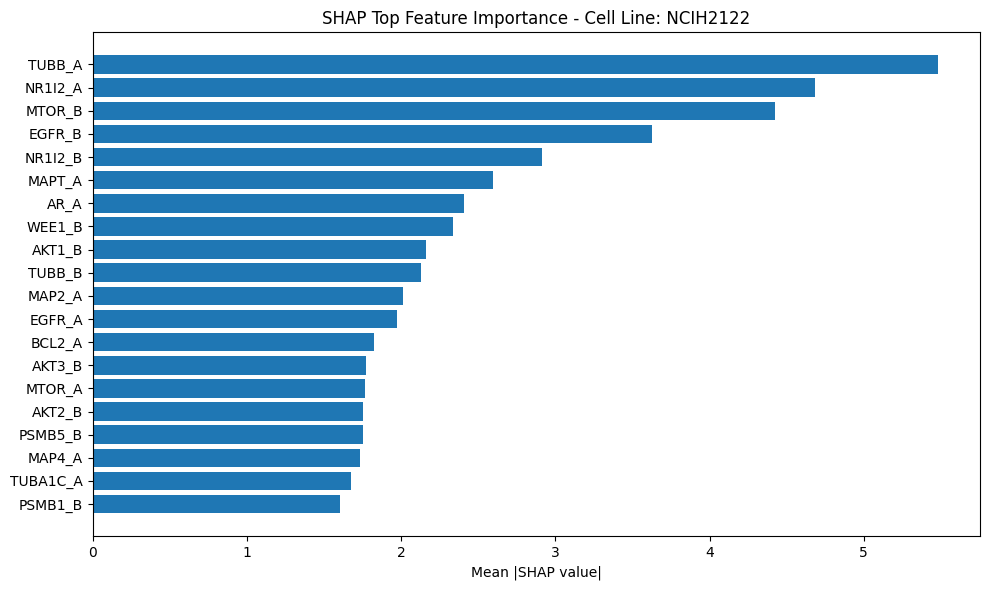

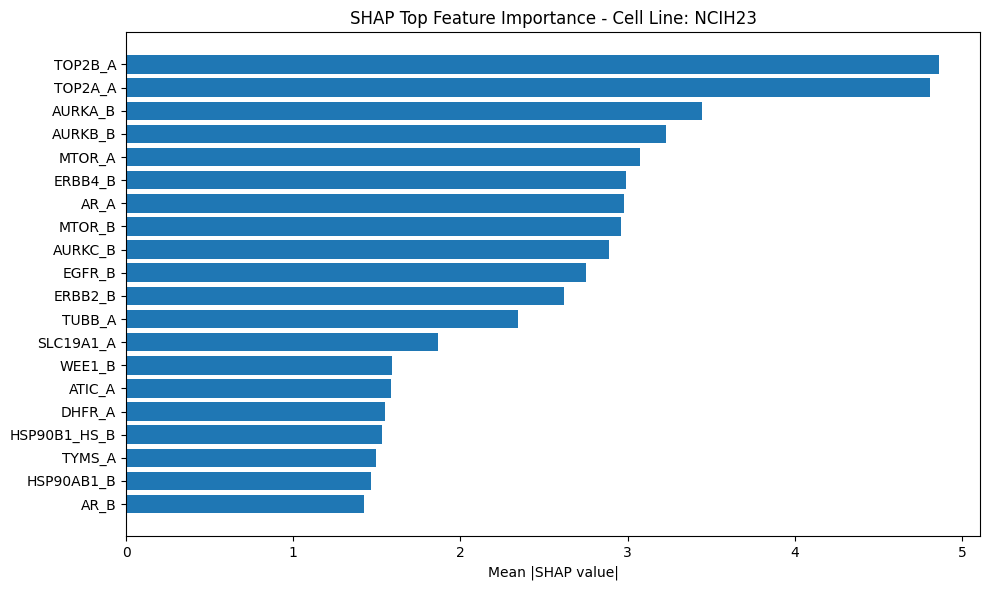

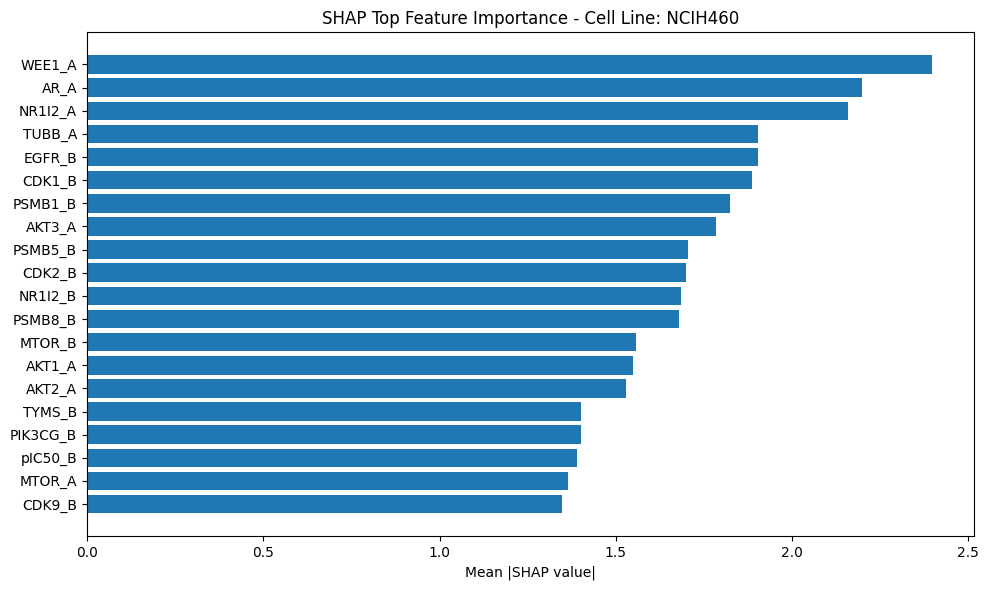

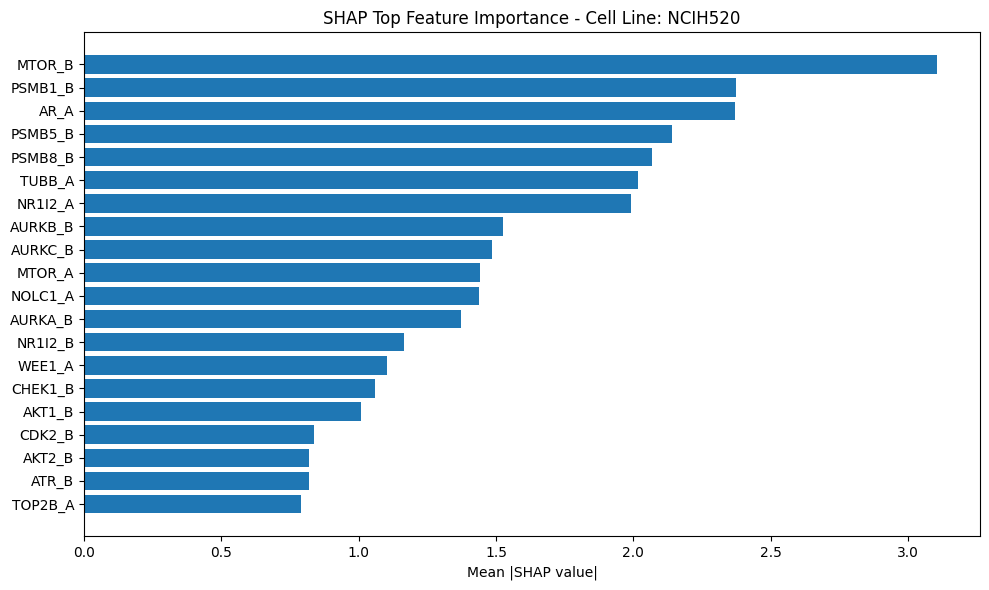

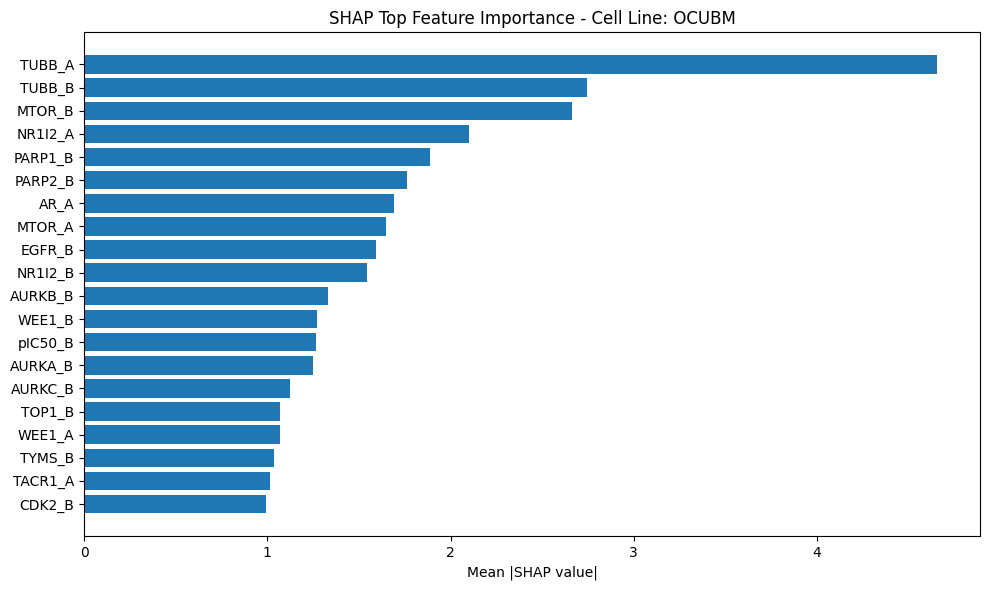

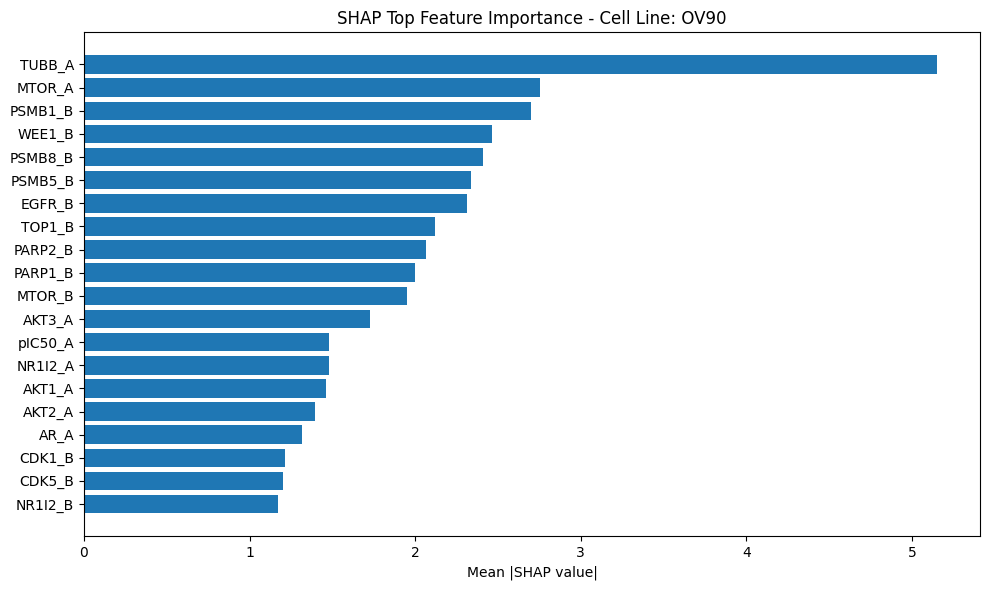

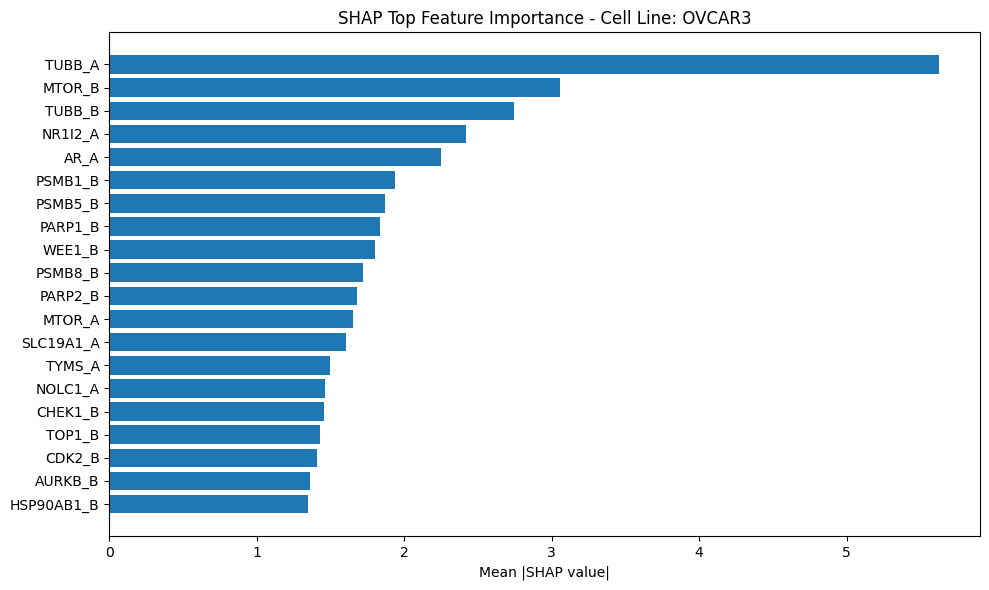

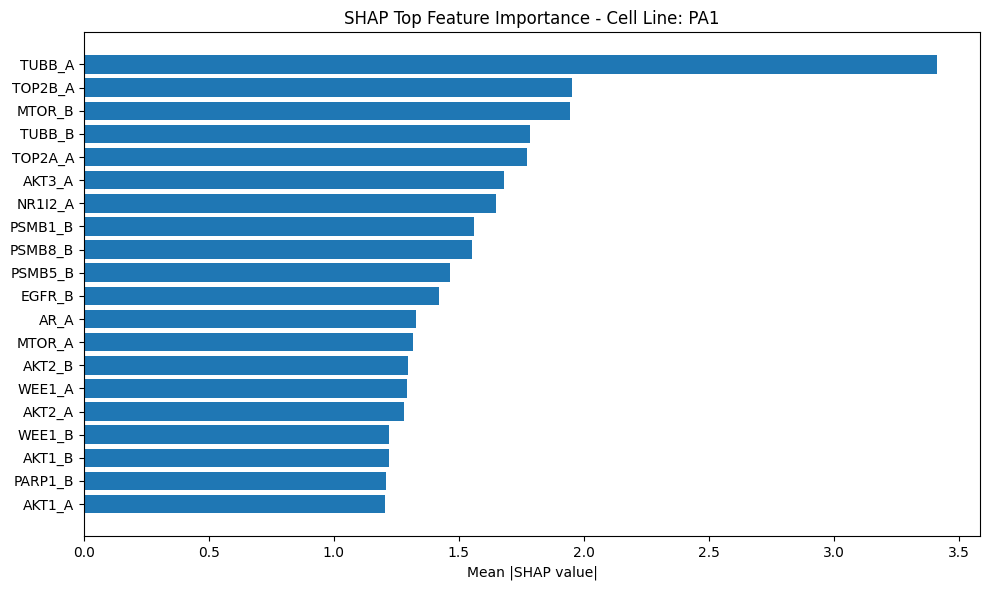

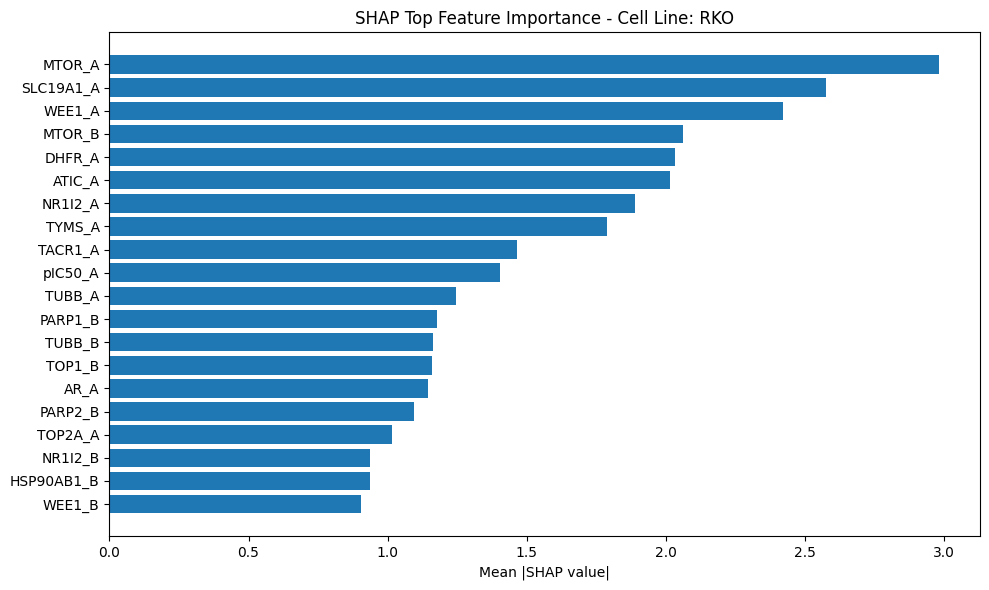

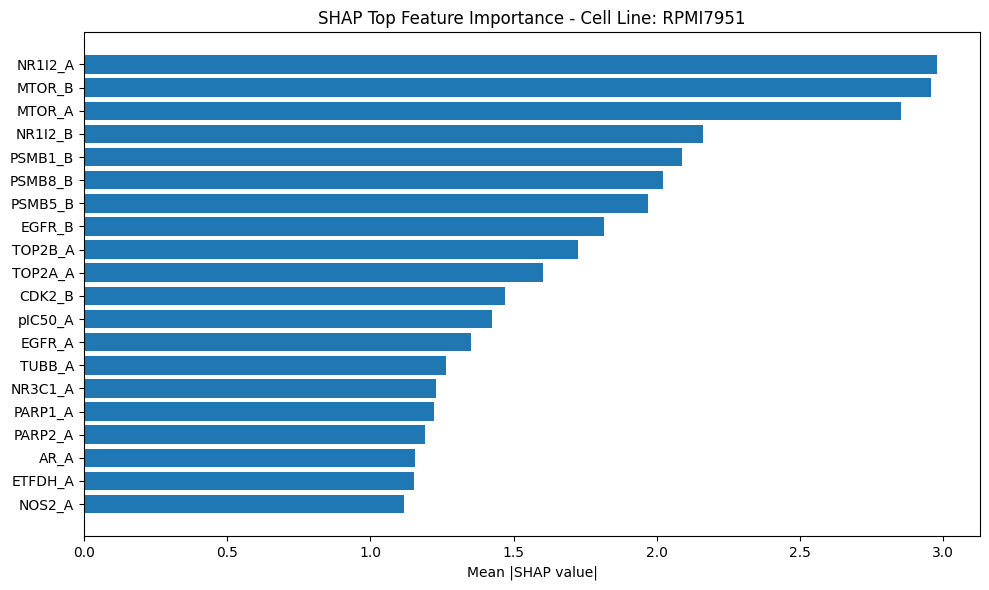

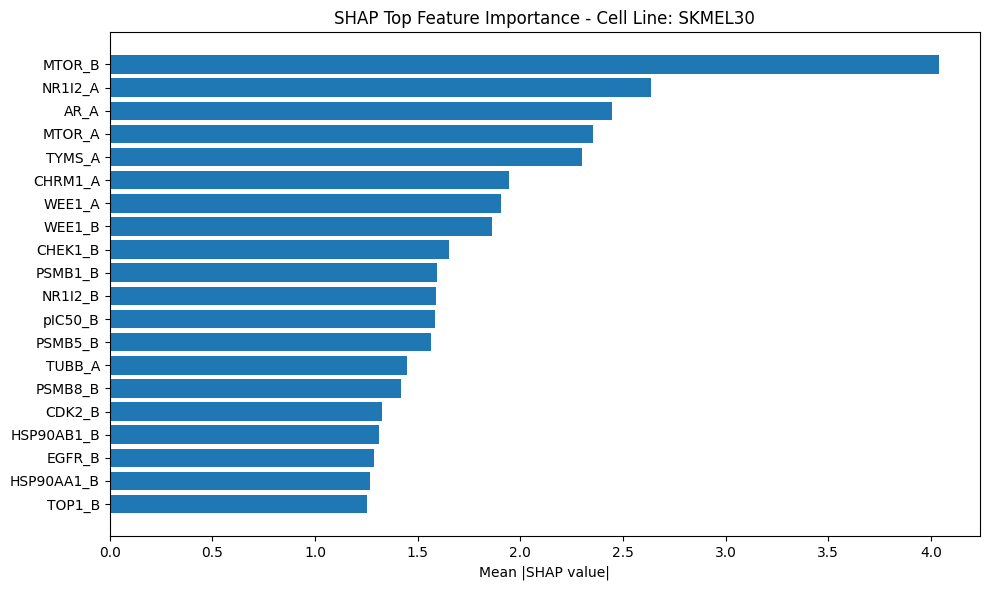

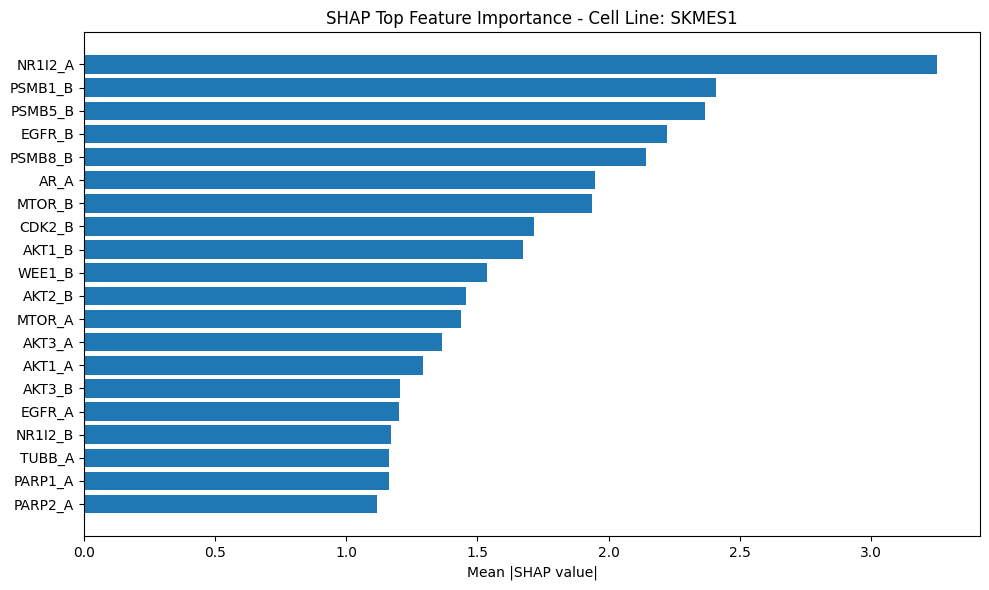

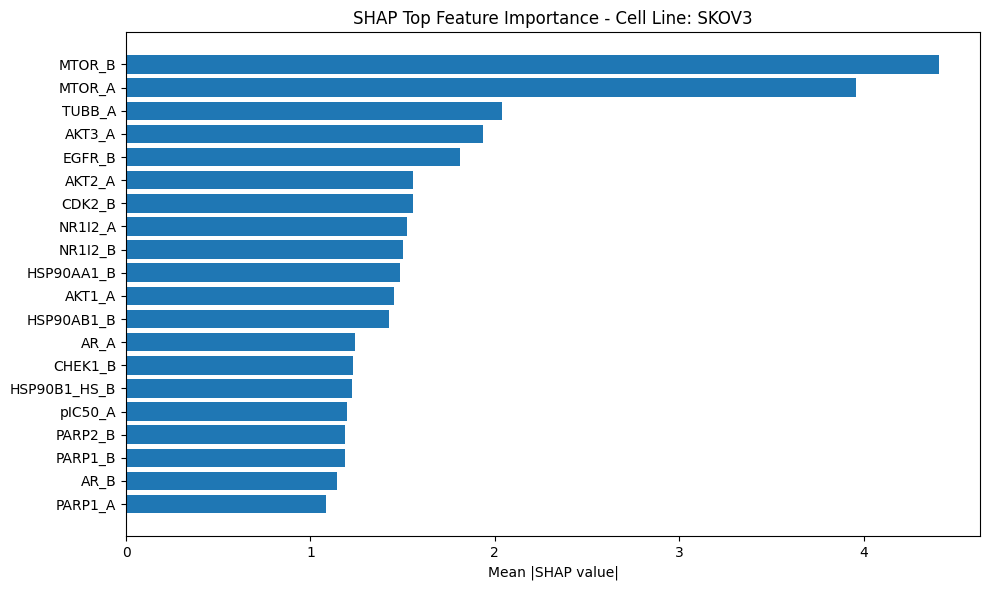

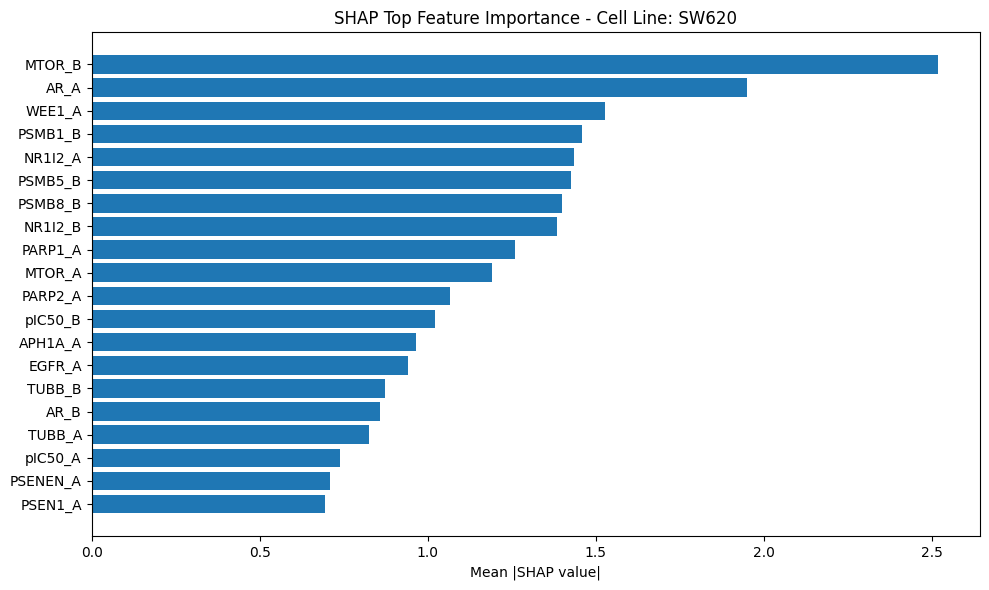

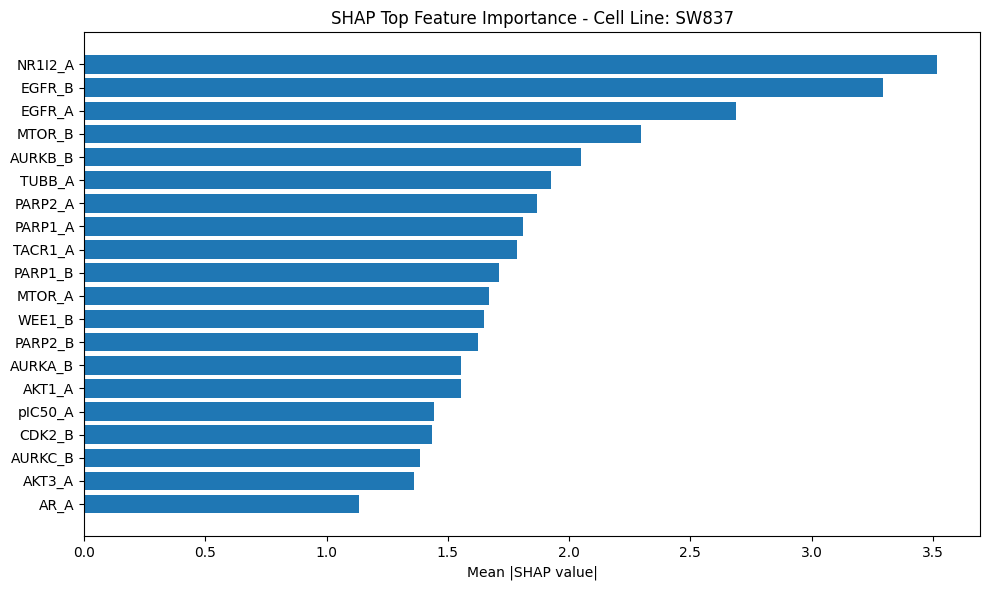

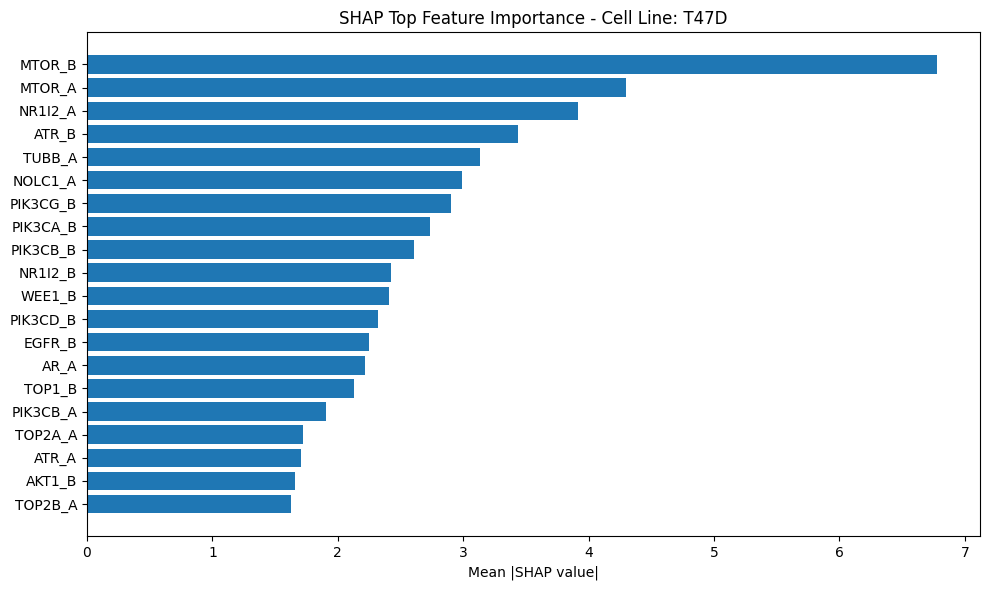

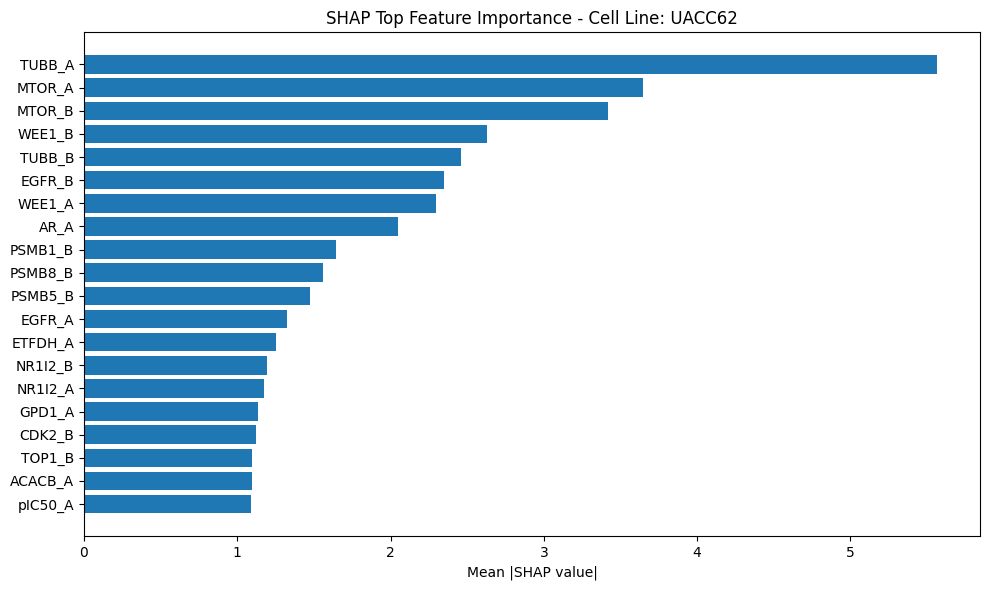

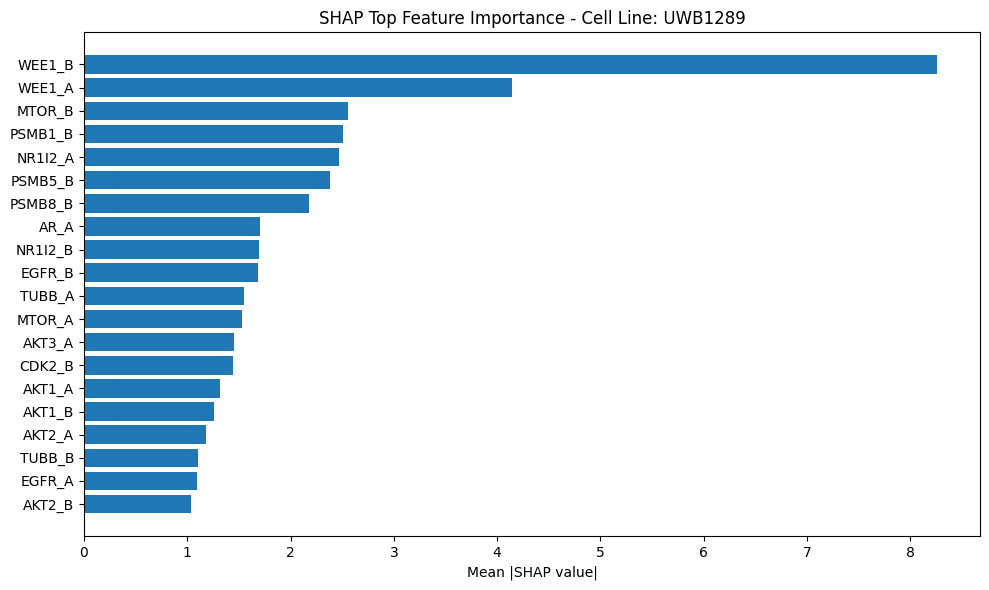

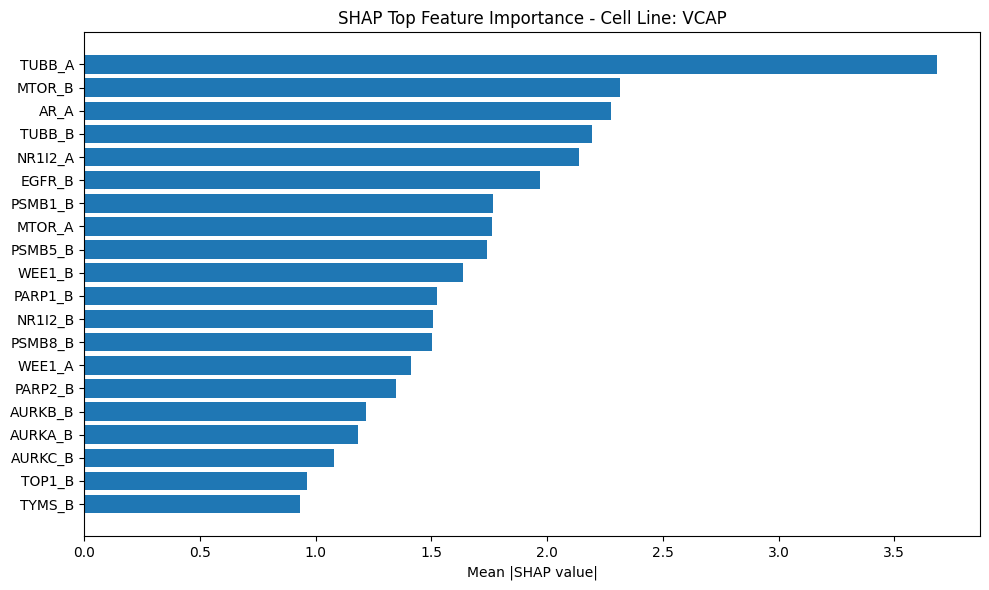

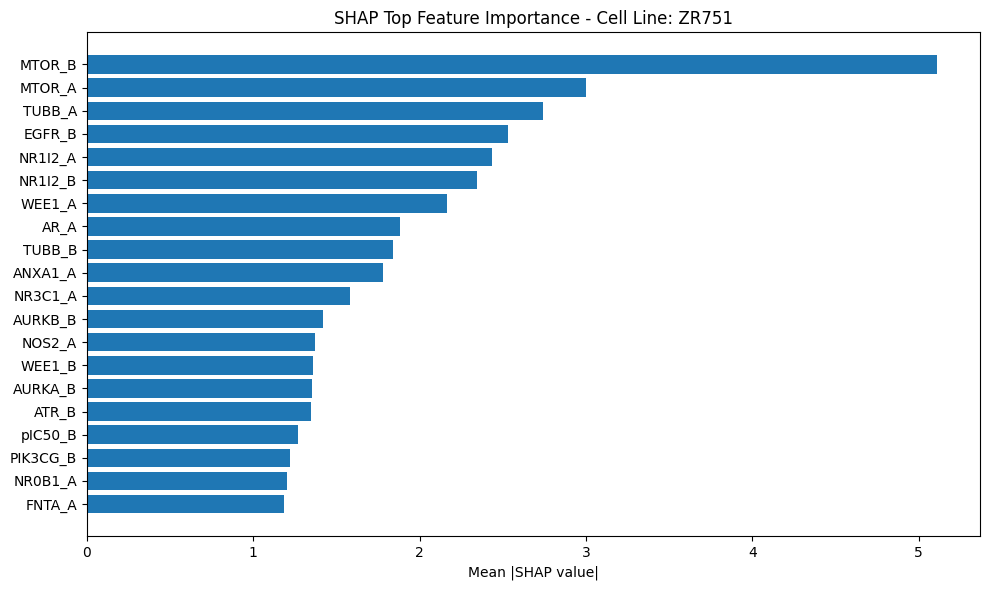

In [6]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_by_cell_line(shap_values, feature_names, tran_indices, top_n=20):
    cell_lines = load_transynergy_cell_line_data(split='test')
    #only get the cell lines that were used for SHAP
    sampled_cell_lines = np.array(cell_lines)[tran_indices]
    
    unique_cell_lines = np.unique(sampled_cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(sampled_cell_lines == cell_line)[0]
        cell_line_shap_values = shap_values[cell_line_indices]
        
        mean_abs_shap = np.mean(np.abs(cell_line_shap_values), axis=0)
        
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": mean_abs_shap
        }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
        plt.xlabel("Mean |SHAP value|")
        plt.title(f"SHAP Top Feature Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_cell_line(tran_shap_values, tran_feature_names, tran_indices)

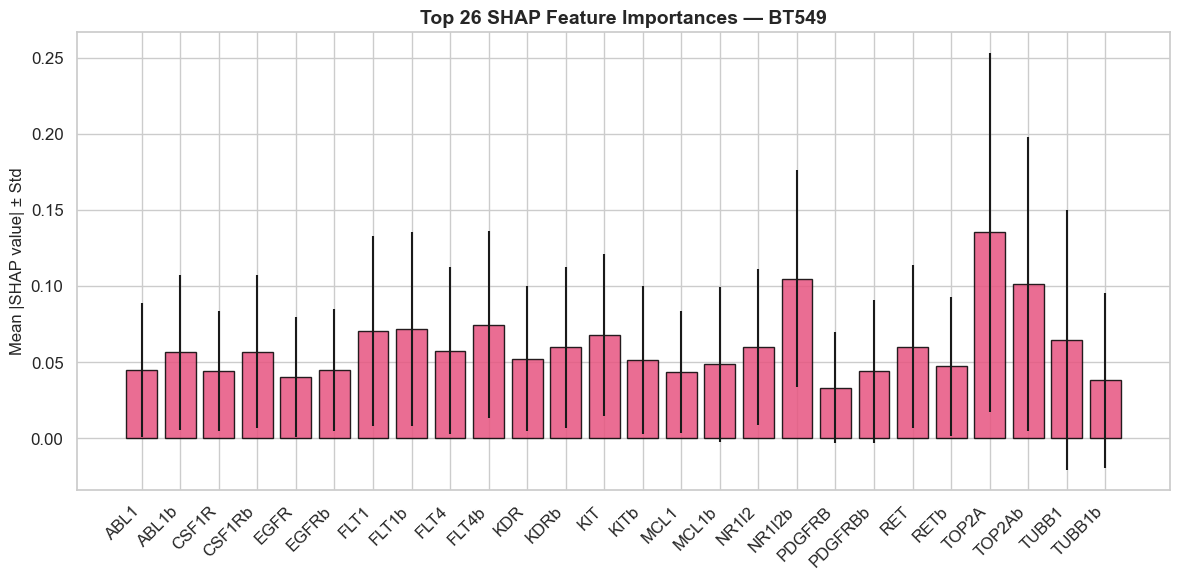

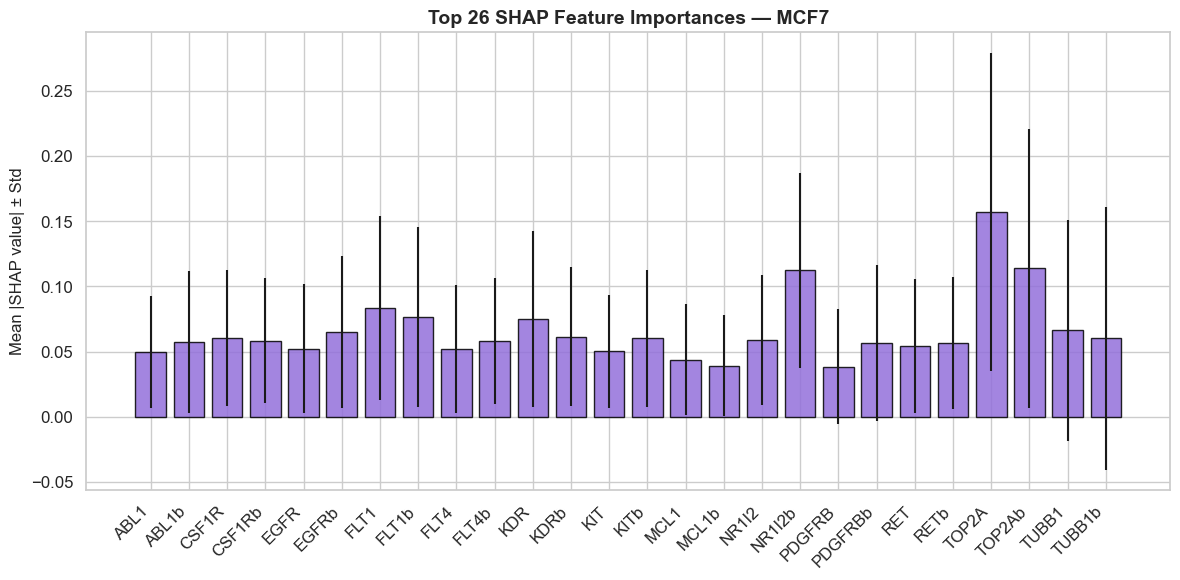

In [19]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_selected_cell_lines_shap(shap_values, feature_names, bio_indices, top_n=26):
    sns.set(style="whitegrid", font_scale=1.1)
    
    cell_lines = load_biomining_cell_line_data(split='test')
    cell_lines = np.concatenate([cell_lines, cell_lines], axis=0)
    sampled_cell_lines = cell_lines[bio_indices]

    target_cell_lines = sorted(["MCF7", "BT549"])
    color_map = {
        "MCF7": "#9370DB",  
        "BT549": "#e75480"  
    }

    mask = np.isin(sampled_cell_lines, target_cell_lines)
    filtered_shap_values = shap_values[mask]
    filtered_cell_lines = sampled_cell_lines[mask]

    for cell_line in target_cell_lines:
        indices = np.where(filtered_cell_lines == cell_line)[0]
        shap_subset = filtered_shap_values[indices]

        shap_subset = shap_subset[:, :-7]
        trimmed_feature_names = feature_names[:-7]

        mean_abs_shap = np.mean(np.abs(shap_subset), axis=0)
        std_abs_shap = np.std(np.abs(shap_subset), axis=0)

        top_indices = np.argsort(mean_abs_shap)[-top_n:]
        top_features = np.array(trimmed_feature_names)[top_indices]
        top_means = mean_abs_shap[top_indices]
        top_stds = std_abs_shap[top_indices]

        sorted_order = np.argsort(top_features)
        top_features = top_features[sorted_order]
        top_means = top_means[sorted_order]
        top_stds = top_stds[sorted_order]

        plt.figure(figsize=(12, 6))
        plt.bar(top_features, top_means, yerr=top_stds,
                color=color_map[cell_line], edgecolor='black', alpha=0.85)
        plt.ylabel("Mean |SHAP value| ± Std", fontsize=12)
        plt.title(f"Top {top_n} SHAP Feature Importances — {cell_line}", fontsize=14, weight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

plot_selected_cell_lines_shap(bio_shap_values, bio_feature_names, bio_indices)




[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


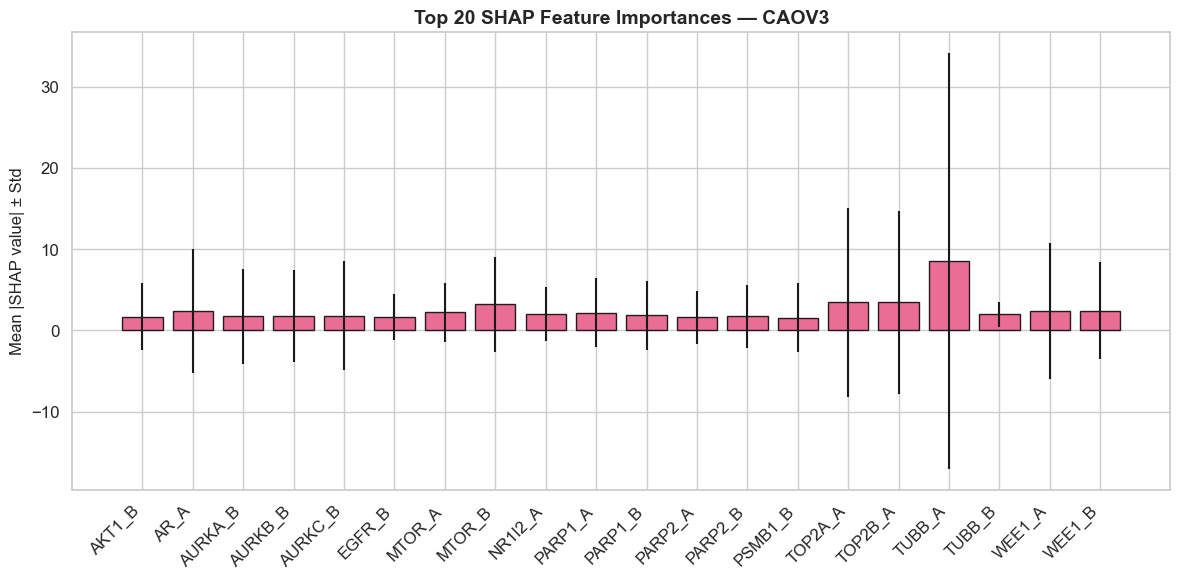

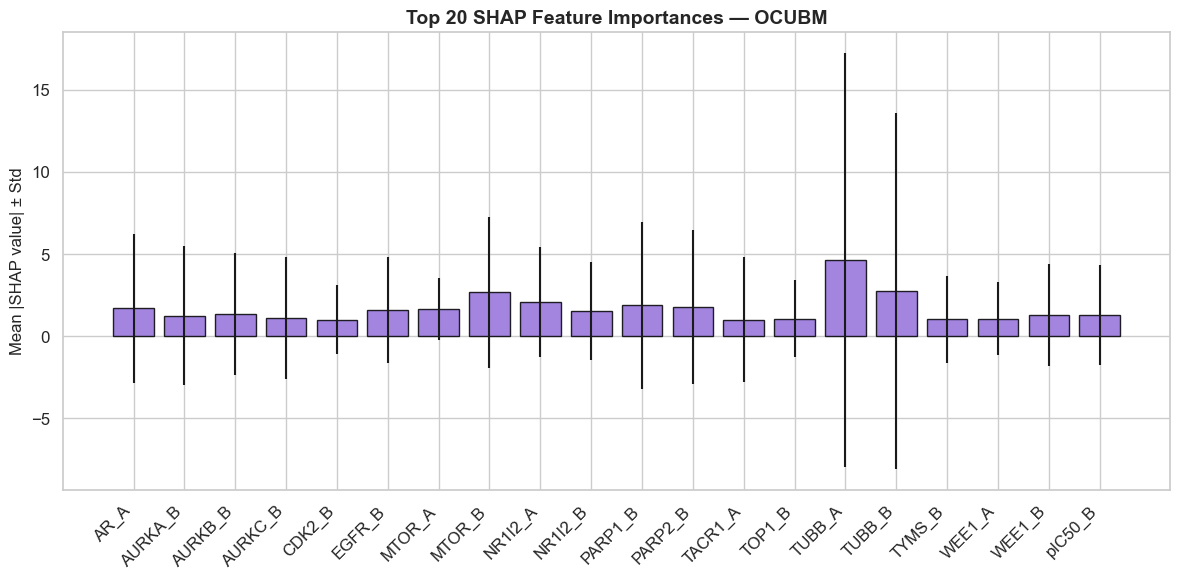

In [20]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_transynergy_shap_by_cell_line(shap_values, feature_names, tran_indices, top_n=20):
    sns.set(style="whitegrid", font_scale=1.1)

    cell_lines = np.array(load_transynergy_cell_line_data(split='test'))
    sampled_cell_lines = cell_lines[tran_indices]

    target_cell_lines = sorted(["CAOV3", "OCUBM"])
    color_map = {
        "CAOV3": "#e75480",  
        "OCUBM": "#9370DB"   
    }

    mask = np.isin(sampled_cell_lines, target_cell_lines)
    filtered_shap = shap_values[mask]
    filtered_cell_lines = sampled_cell_lines[mask]

    for cell_line in target_cell_lines:
        indices = np.where(filtered_cell_lines == cell_line)[0]
        shap_subset = filtered_shap[indices]

        shap_subset = shap_subset[:, :-2402]
        trimmed_features = feature_names[:-2402]

        mean_abs_shap = np.mean(np.abs(shap_subset), axis=0)
        std_abs_shap = np.std(np.abs(shap_subset), axis=0)

        top_indices = np.argsort(mean_abs_shap)[-top_n:]
        top_features = np.array(trimmed_features)[top_indices]
        top_means = mean_abs_shap[top_indices]
        top_stds = std_abs_shap[top_indices]

        sorted_order = np.argsort(top_features)
        top_features = top_features[sorted_order]
        top_means = top_means[sorted_order]
        top_stds = top_stds[sorted_order]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(top_features, top_means, yerr=top_stds,
                       color=color_map[cell_line], edgecolor='black', alpha=0.85)
        plt.ylabel("Mean |SHAP value| ± Std", fontsize=12)
        plt.title(f"Top {top_n} SHAP Feature Importances — {cell_line}", fontsize=14, weight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

plot_transynergy_shap_by_cell_line(tran_shap_values, tran_feature_names, tran_indices)

